In [2]:
import numpy as np
import datetime as dt
import scipy.signal as scs
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel
import sys
sys.path.append('D:\\gitCCA\\CESdesign\\py')
import CESfunctions_dev as cf

In [ ]:
ramafolder = 'D:\\CCA\\Avantes\\BBCEAS_Data\\RAMA\\'
mfolder = 'D:\\CCA\\Avantes\\BBCEAS_Data\\'

ramafile1 = 'CCA_20220315_M.csv'
ramafile2 = 'CCA_20220316_M.csv'
#ramafile3 = 'CCA_20220317_M.csv'

mfile1 = '20220315\\M2203151245_r.txt'
mfile2 = '20220315\\M2203161014_r.txt'
mfile3 = '20220316\\M2203161245_r.txt'
mfile4 = '20220316\\M2203171312_r.txt'

dateM1,ppb1M1,ppb2M1,intM1 = cf.Mfile_read(mfolder+mfile1)
dateM2,ppb1M2,ppb2M2,intM2 = cf.Mfile_read(mfolder+mfile2)
dateM3,ppb1M3,ppb2M3,intM3 = cf.Mfile_read(mfolder+mfile3)
dateM4,ppb1M4,ppb2M4,intM4 = cf.Mfile_read(mfolder+mfile4)

dateR1,ppbR1 = cf.RAMA_read(ramafolder+ramafile1)
dateR2,ppbR2 = cf.RAMA_read(ramafolder+ramafile2)


In [ ]:
dateR1d=[]
for ele in dateR1:
    dateR1d.append(ele-dt.timedelta(minutes=8))
dateR2d=[]
for ele in dateR2:
    dateR2d.append(ele-dt.timedelta(minutes=8))
    
dateR=dateR1d[:-60]+dateR2d[60:]
ppbR=ppbR1[:-60]+ppbR2[60:]
dateM=dateM1+dateM2+dateM3+dateM4
ppb1M=ppb1M1+ppb1M2+ppb1M3+ppb1M4

In [ ]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

ax1.plot(dateM,ppb1M,'--k',alpha=0.25)
ax1.plot(dateM,scs.savgol_filter(ppb1M,21,3),'-k', label="BBCEAS")
ax1.plot(dateR,ppbR,'-r', label="RAMA")
ax1.set_ylim(-1,65)
ax1.set_xlabel('Time',size=14)
ax1.set_ylabel('NO$_2$ ppb',size=14)
ax1.set_title("Measurements March 15-17 2022",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))


In [ ]:
zipped = list(zip(dateR,ppbR))
df1 = pd.DataFrame(zipped, columns=['Date', 'NO2_RAMA'])
ts1=df1.set_index('Date')
zipped = list(zip(dateM,ppb1M))
df2 = pd.DataFrame(zipped, columns=['Date', 'NO2_CEAS'])
ts2=df2.set_index('Date')


In [ ]:
#ts1f=ts1[(ts1.NO2_RAMA<70)&(ts1.NO2_RAMA>5)] 
ts2m=ts2.resample('T').mean().dropna()

In [ ]:
tscommon = pd.merge(ts1, ts2m, how='inner', on=['Date'])
tscommon

In [ ]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

ax1.plot(tscommon.index,tscommon.NO2_CEAS,'-k',label="BBCEAS")
ax1.plot(tscommon.index,tscommon.NO2_RAMA,'-r', label="RAMA")
ax1.set_ylim(-1,65)
ax1.set_xlabel('Time (Day-Hour)',size=14)
ax1.set_ylabel('NO$_2$ ppb',size=14)
ax1.set_title("Measurements March 15-16 2022",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.xaxis.set_major_formatter(DateFormatter("%d-%H"))
plt.savefig("March 15-16 (minute)")

In [ ]:
model = LinearModel()

# create parameters with initial values
params = model.make_params(intercept=0, slope=1)
params['intercept'].vary=False

# do the fit, print out report with results 
result1= model.fit(tscommon.NO2_RAMA, params, x=tscommon.NO2_CEAS)
print(result.fit_report())

### redo it with free intercept
params['intercept'].vary=True
# do the fit, print out report with results 
result2 = model.fit(tscommon.NO2_RAMA, params, x=tscommon.NO2_CEAS)
print(result2.fit_report())

In [ ]:
print(1 - result1.residual.var() / np.var(tscommon.NO2_CEAS))
print(1 - result2.residual.var() / np.var(tscommon.NO2_CEAS))

In [ ]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

ax1.plot(tscommon.NO2_CEAS,tscommon.NO2_RAMA,'.k',alpha=.25)
ax1.plot(tscommon.NO2_CEAS,result1.best_fit,'-r',label="y=1.0406x, R$^2$=0.9132")
ax1.plot(tscommon.NO2_CEAS,result2.best_fit,'-b',label="y=0.8084x+6.0630, R$^2$=0.9438")
ax1.set_ylim(-1,65)
ax1.set_xlabel('BBCEAS',size=14)
ax1.set_ylabel('RAMA',size=14)
ax1.set_title("NO$_2$ ppb : March 15-16 2022 (Reprocessed)",size=16)
ax1.legend(fontsize=12, loc='upper left')
plt.savefig("Mar15-16_fit_r.png")

In [66]:
##### Alternatively for accumulated, we use Mfile for both since they have the right formatting
folder="D:\\CCA\\ICACC-BBCEAS\\"
dateM,ppb1M,ppb2M,intM = cf.Mfile_read(folder+"dataset1\\Mfile_accum_r_dataset.txt")
dateR,ppb1R,ppb2R,intR = cf.Mfile_read(folder+"RAMA\\RAMA_20220101_20220725.txt")
dateRd=[]
for ele in dateR:
    dateRd.append(ele-dt.timedelta(minutes=8))

In [67]:
##### making them pandas timeseries
zipped = list(zip(dateRd,ppb1R))
df1 = pd.DataFrame(zipped, columns=['Date', 'NO2_RAMA'])
ts1=df1.set_index('Date')
zipped = list(zip(dateM,ppb1M))
df2 = pd.DataFrame(zipped, columns=['Date', 'NO2_CEAS'])
ts2=df2.set_index('Date')


##### Resampling CEAS data
ts2m=ts2.resample('T').mean().dropna()


##### Finding common elements
tscommon = pd.merge(ts1, ts2m, how='inner', on=['Date'])
tscommon

,NO2_RAMA,NO2_CEAS
Date,,
2022-01-25 11:51:00,4.54,0.211073
2022-01-25 11:52:00,4.64,2.629885
2022-01-25 11:53:00,4.71,3.803035
2022-01-25 11:54:00,4.82,4.863073
2022-01-25 11:55:00,4.78,4.124518
...,...,...
2022-03-17 13:08:00,7.90,6.017884
2022-03-17 13:09:00,7.97,7.734275
2022-03-17 13:10:00,7.96,6.905686


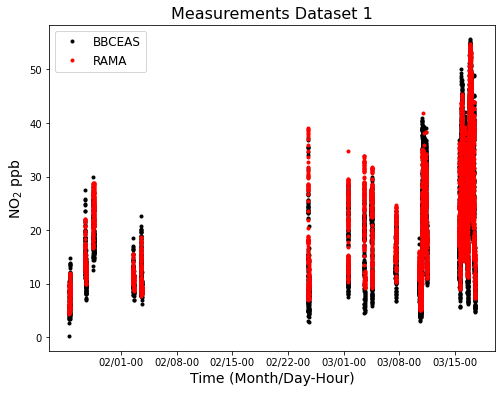

In [68]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

ax1.plot(tscommon.index,tscommon.NO2_CEAS,'.k',label="BBCEAS")
ax1.plot(tscommon.index,tscommon.NO2_RAMA,'.r', label="RAMA")
#ax1.set_ylim(-1,65)
ax1.set_xlabel('Time (Month/Day-Hour)',size=14)
ax1.set_ylabel('NO$_2$ ppb',size=14)
ax1.set_title("Measurements Dataset 1",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.xaxis.set_major_formatter(DateFormatter("%m/%d-%H"))

In [69]:
model = LinearModel()

# create parameters with initial values
params = model.make_params(intercept=0, slope=1)
params['intercept'].vary=False

# do the fit, print out report with results 
result1= model.fit(tscommon.NO2_RAMA, params, x=tscommon.NO2_CEAS)
print(result1.fit_report())

### redo it with free intercept
params['intercept'].vary=True
# do the fit, print out report with results 
result2 = model.fit(tscommon.NO2_RAMA, params, x=tscommon.NO2_CEAS)
print(result2.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 5763
    # variables        = 1
    chi-square         = 51497.7251
    reduced chi-square = 8.93747398
    Akaike info crit   = 12623.4279
    Bayesian info crit = 12630.0871
[[Variables]]
    slope:      1.00130977 +/- 0.00157852 (0.16%) (init = 1)
    intercept:  0 (fixed)
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 5763
    # variables        = 2
    chi-square         = 42869.3738
    reduced chi-square = 7.44130772
    Akaike info crit   = 11568.6092
    Bayesian info crit = 11581.9277
[[Variables]]
    slope:      0.90898360 +/- 0.00307018 (0.34%) (init = 1)
    intercept:  2.60817503 +/- 0.07659447 (2.94%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.883


In [70]:
print(1-result1.residual.var() / np.var(tscommon.NO2_CEAS))
print(1-result2.residual.var() / np.var(tscommon.NO2_CEAS))

0.9371726154591241
0.9456967358244022


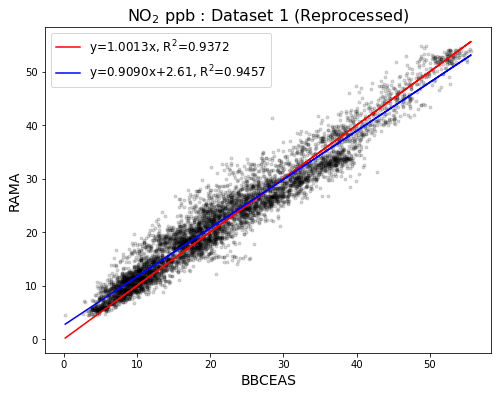

In [73]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

ax1.plot(tscommon.NO2_CEAS,tscommon.NO2_RAMA,'.k',alpha=.15)
ax1.plot(tscommon.NO2_CEAS,result1.best_fit,'-r',label="y=1.0013x, R$^2$=0.9372")
ax1.plot(tscommon.NO2_CEAS,result2.best_fit,'-b',label="y=0.9090x+2.61, R$^2$=0.9457")
#ax1.set_ylim(-1,65)
ax1.set_xlabel('BBCEAS',size=14)
ax1.set_ylabel('RAMA',size=14)
ax1.set_title("NO$_2$ ppb : Dataset 1 (Reprocessed)",size=16)
ax1.legend(fontsize=12, loc='upper left')
#plt.savefig("Mar15-16_fit_r.png")

In [60]:
tscommon[tscommon.NO2_RAMA>80]

,NO2_RAMA,NO2_CEAS
Date,,
2022-03-16 23:47:00,86.81,48.7293


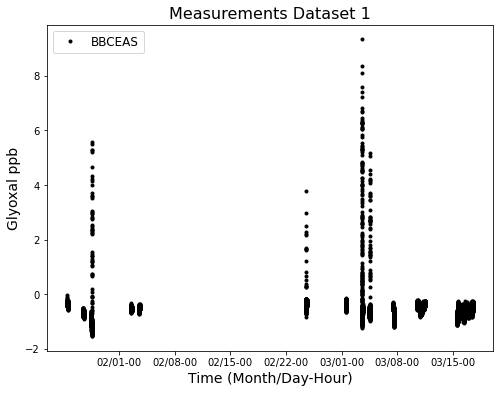

In [74]:
f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

ax1.plot(dateM,ppb2M,'.k',label="BBCEAS")
#ax1.set_ylim(-1,65)
ax1.set_xlabel('Time (Month/Day-Hour)',size=14)
ax1.set_ylabel('Glyoxal ppb',size=14)
ax1.set_title("Measurements Dataset 1",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.xaxis.set_major_formatter(DateFormatter("%m/%d-%H"))